In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#SOPR
SOPR = pd.read_csv("data/bitcoin-spent-output-profit-ratio-sopr.csv")

SOPR["SOPR/t"] = SOPR["SOPR/t"].str.rstrip("T00:00:00.000Z")
SOPR["SOPR/t"] = pd.to_datetime(SOPR["SOPR/t"])
SOPR = SOPR.sort_values(by='SOPR/t')
SOPR = SOPR.rename(columns={'SOPR/t': 'Timestamp', 'SOPR/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
SOPR = SOPR[~(SOPR['Timestamp'] < '2010-01-01')]
SOPR = SOPR[~(SOPR['Timestamp'] > '2021-12-31')]

#fixing index
SOPR.reset_index(drop=True, inplace=True)

#Description
print(SOPR.head())
print("\nShape is:", SOPR.shape)
print("\nSummary of the dataset:")
SOPR.describe()
print("\nAre there null values?")
SOPR.isna().sum()

   Timestamp     Value
0 2012-12-31  1.012306
1 2013-01-01  0.998396
2 2013-01-01  1.014277
3 2013-01-02  0.999711
4 2013-01-02  1.007465

Shape is: (3288, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
SOPR['year'] = [d.year for d in SOPR["Timestamp"]]

In [4]:
SOPR.year.unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [5]:
SOPR.year.value_counts()

2016    366
2020    366
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
2012      1
Name: year, dtype: int64

# VISUALIZATION

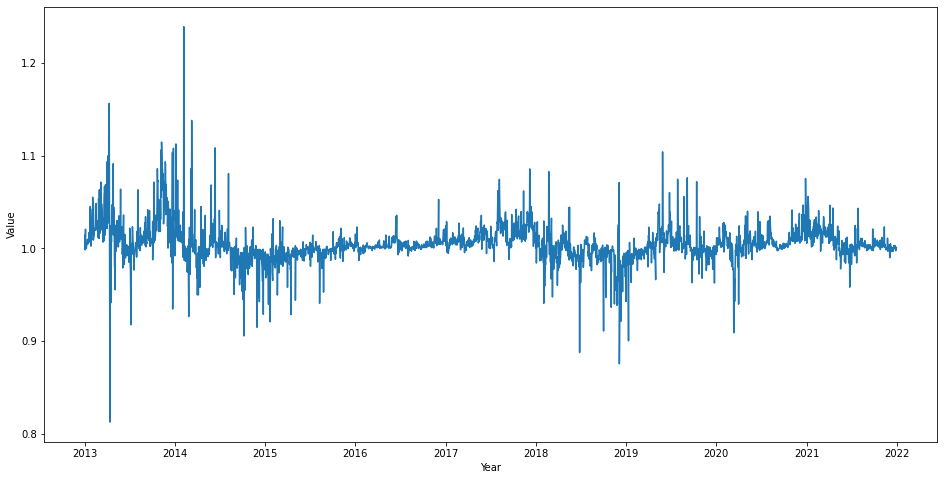

In [6]:
plt.figure(figsize=(16,8))
plt.plot(SOPR["Timestamp"], SOPR["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


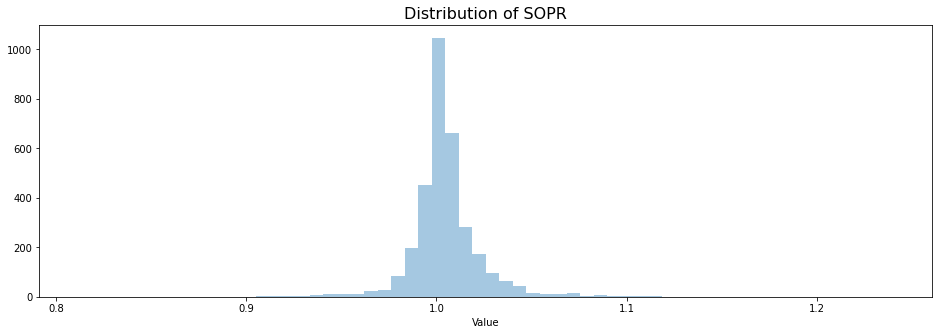

In [7]:
plt.figure(figsize=(16,5))
sns.distplot(SOPR["Value"], kde = False, bins = 60)
plt.title('Distribution of SOPR', fontsize=16)
plt.show()

#### Shorter time series
Same as market price

In [8]:
SOPR["Value"][SOPR["Timestamp"].dt.year == 2014].mean()
SOPRh = SOPR.loc[(SOPR["Timestamp"].dt.year > 2016) & (SOPR["Timestamp"].dt.year < 2022),:]
SOPRn = SOPR.loc[(SOPR["Timestamp"].dt.year > 2016) & (SOPR["Timestamp"].dt.year < 2021),:]
SOPRnh = SOPR.loc[(SOPR["Timestamp"].dt.year > 2012) & (SOPR["Timestamp"].dt.year < 2021),:]
SOPRf = SOPR.loc[(SOPR["Timestamp"].dt.year > 2012) & (SOPR["Timestamp"].dt.year < 2022),:]

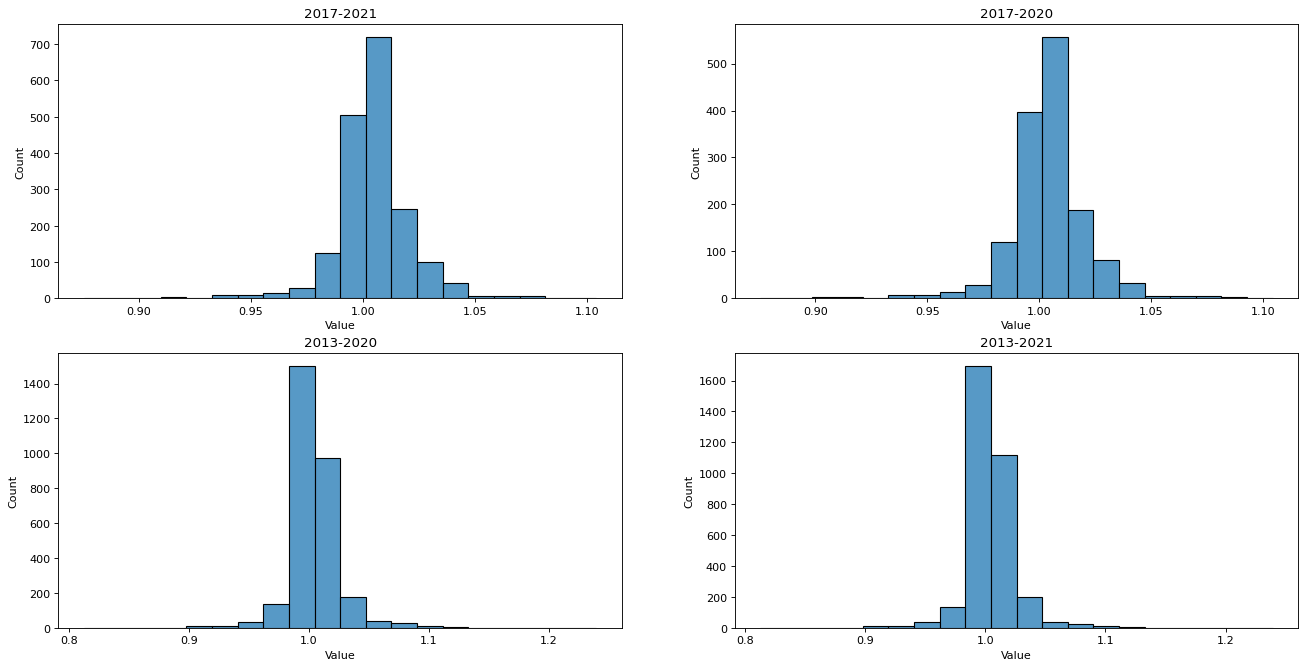

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(SOPRh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(SOPRn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(SOPRnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(SOPRf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

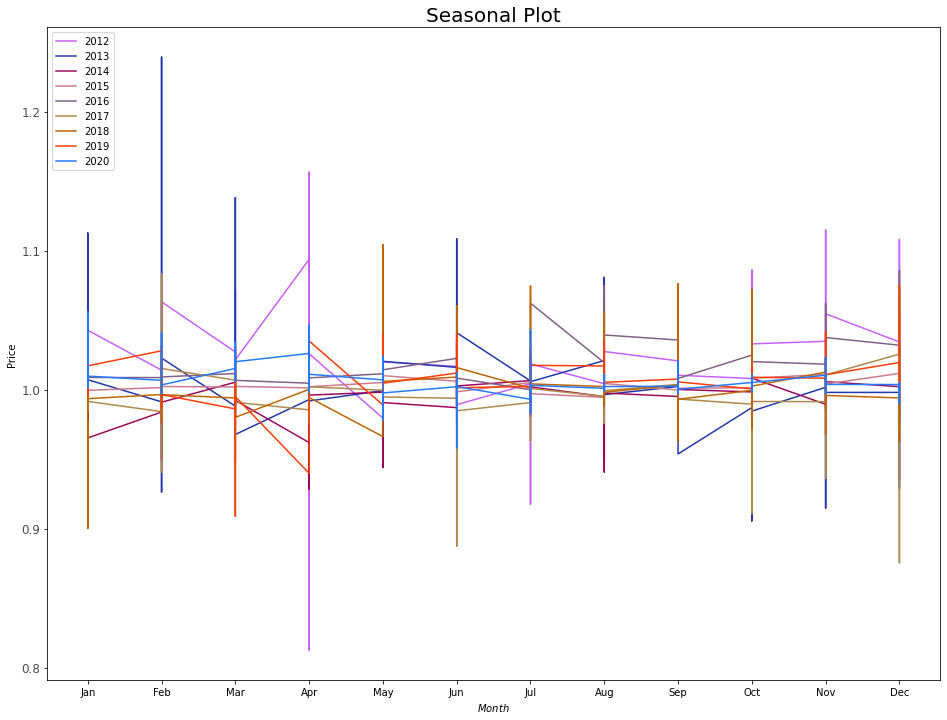

In [11]:
# Prepare data
SOPR['year'] = [d.year for d in SOPR["Timestamp"]]
SOPR['month'] = [d.strftime('%b') for d in SOPR["Timestamp"]]
years = SOPR['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=SOPR.loc[SOPR.year==y, :], color=mycolors[i], label=y)
        
# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

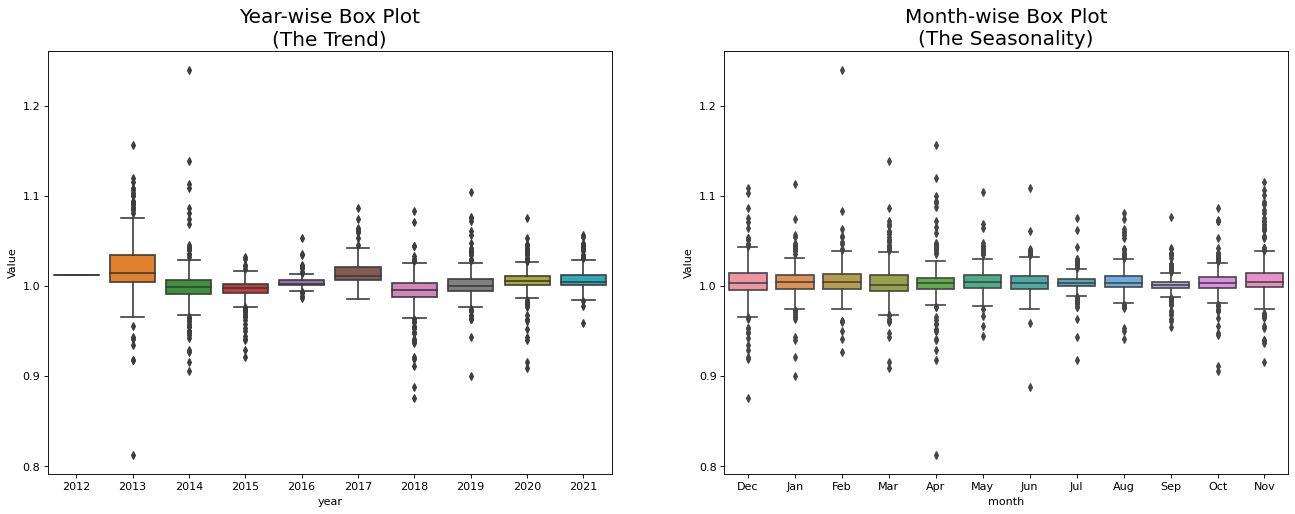

In [12]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=SOPR, ax=axes[0])
sns.boxplot(x='month', y="Value", data=SOPR.loc[~SOPR.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Text(0.5, 0.98, 'SOPR / 2010-2021 ')

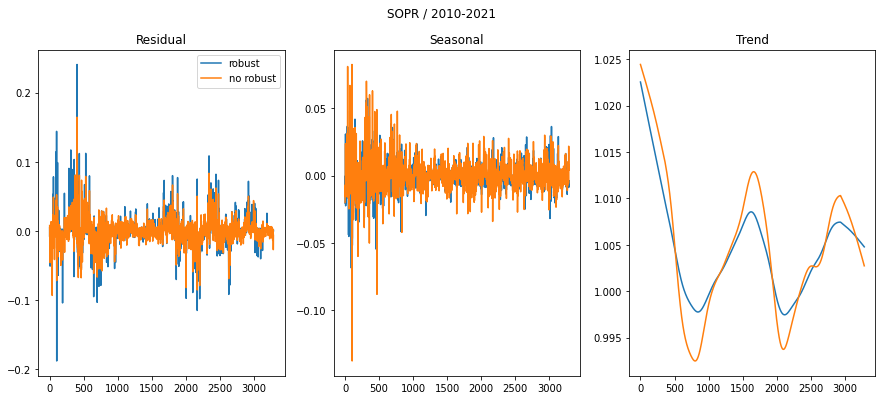

In [13]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(SOPR["Value"], period=365, robust=True).fit()
res2 = STL(SOPR["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('SOPR / 2010-2021 ')

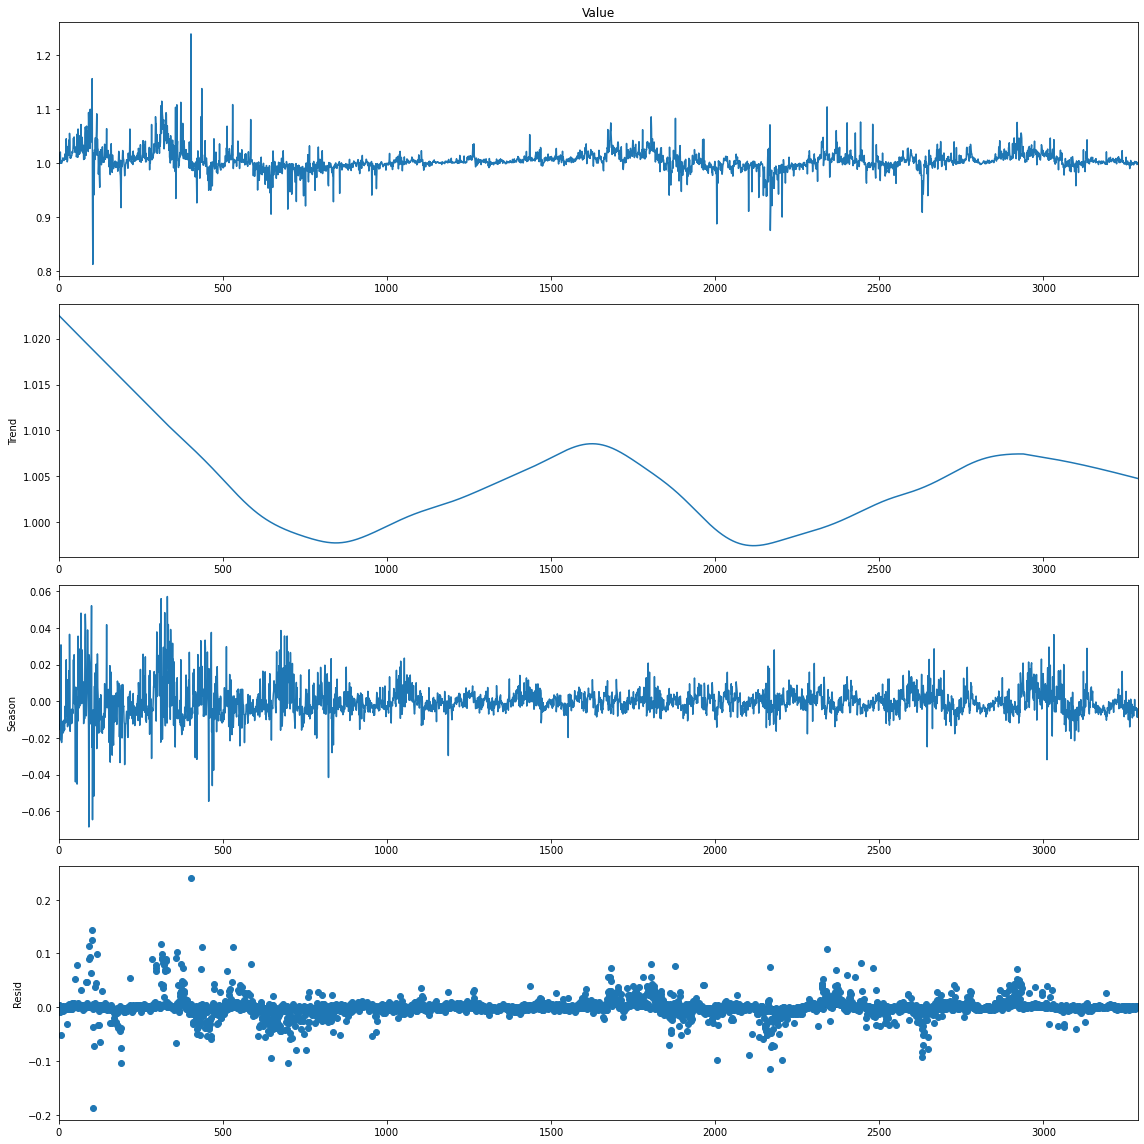

In [14]:
fig = res1.plot() #BIGGER VIEW

Text(0.5, 0.98, 'SOPR / 2017-2021 ')

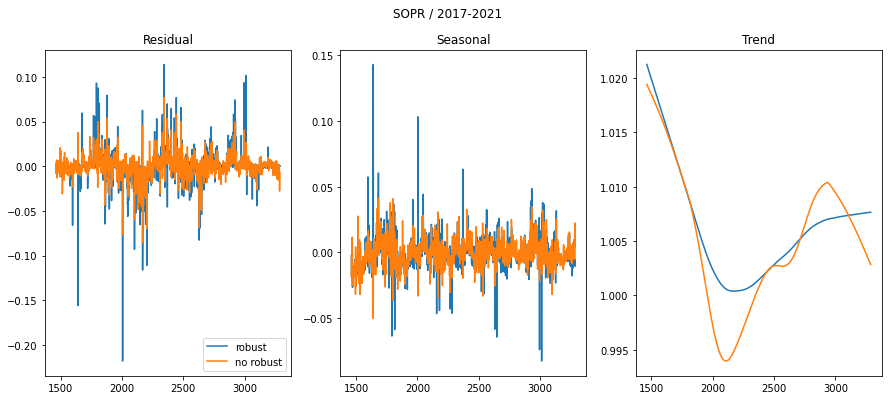

In [15]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(SOPRh["Value"], period=365, robust=True).fit()
res4 = STL(SOPRh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('SOPR / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [16]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

1462    0.021028
1463    0.020993
1464    0.020958
1465    0.020922
1466    0.020887
          ...   
3283    0.007624
3284    0.007626
3285    0.007627
3286    0.007629
3287    0.007630
Name: trend, Length: 1826, dtype: float64

In [17]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(SOPRh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(SOPRh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

array([-3.43139723e-06,  9.48418613e-03])

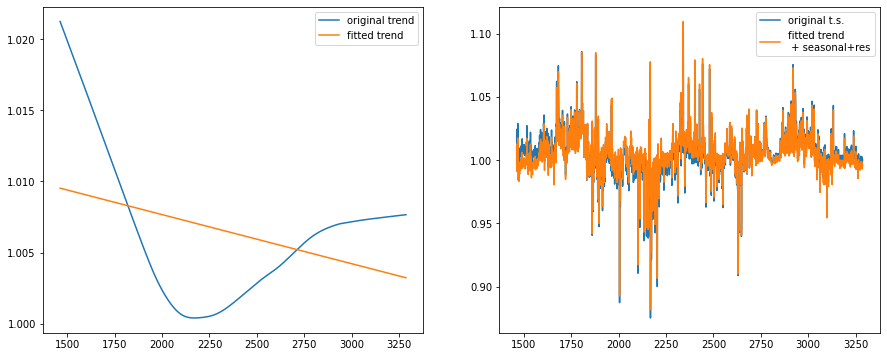

In [18]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(SOPRh))+1)), index = SOPRh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(SOPRh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [19]:
series = SOPR['Value']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(SOPR.Timestamp == train_split_date)[0][0]
x_train = SOPR.loc[SOPR['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-06-29'
test_split_index = np.where(SOPR.Timestamp == test_split_date)[0][0]
x_test = SOPR.loc[SOPR['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = SOPR.loc[(SOPR['Timestamp'] < test_split_date) & (SOPR['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-01 to 2020-12-31 00:00:00 - Number of days = 2923
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


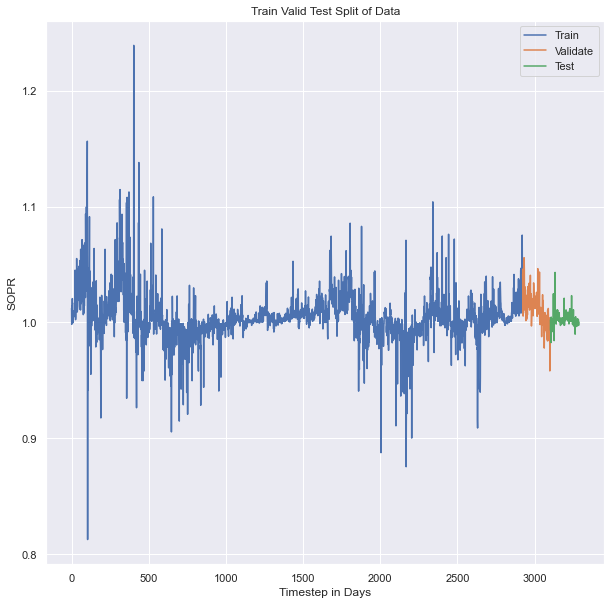

In [23]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-01 to", SOPR.iloc[2922]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", SOPR.iloc[x_valid.index.min()]["Timestamp"], "to", SOPR.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", SOPR.iloc[x_test.index.min()]["Timestamp"], "to", SOPR.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [24]:
len(x_train.index)

2923

In [25]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


Text(0.5, 1.0, 'SOPR')

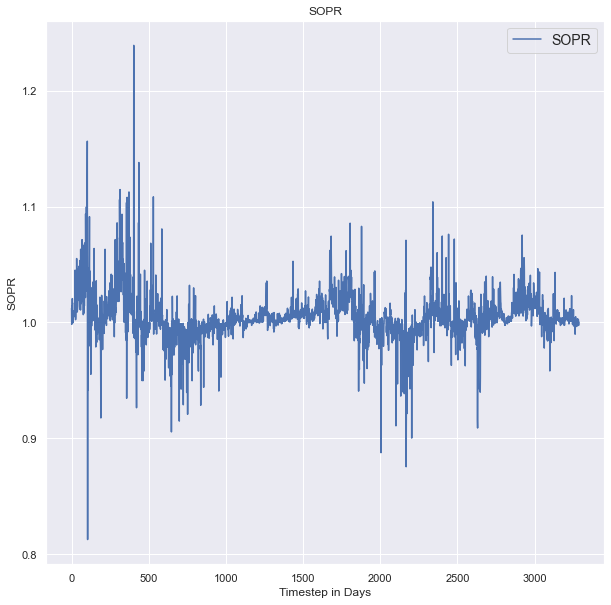

In [27]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=SOPR.index,series=SOPR['Value'], label = 'SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SOPR')

In [28]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'SOPR Forecast vs Actual')

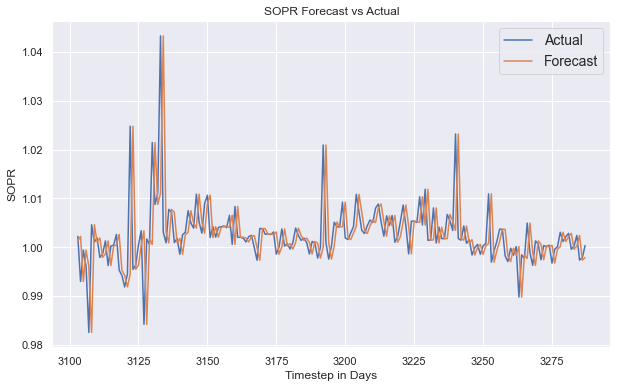

In [29]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SOPR Forecast vs Actual')

## Calculate Error in Naive Model

In [30]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 0.004408076902271792}

In [31]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[1.00129631 1.0022583  0.99303788]
[1.0022583  0.99303788 0.99947217]
****************************************************************************************************
[0.00096199 0.00922042 0.00643429]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

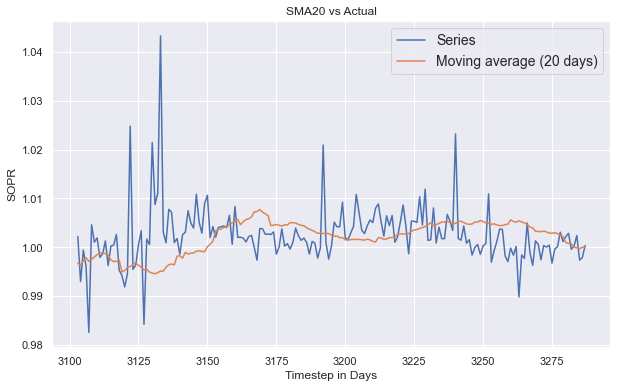

In [32]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = SOPR['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:SOPR.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [33]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 0.004408076902271792, 'SMA 20': 0.004620236002363955}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

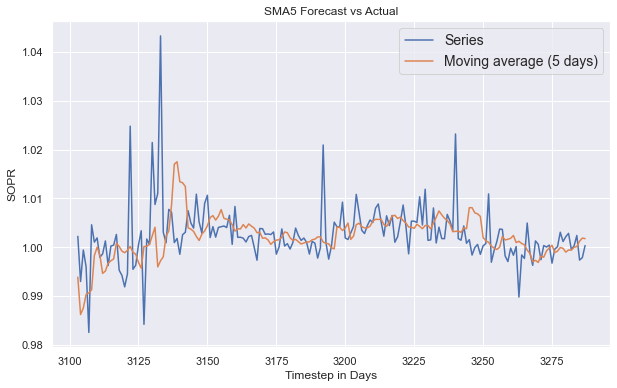

In [34]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = SOPR['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:SOPR.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [35]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.004620236002363955,
 'SMA 5': 0.003988186526800129}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

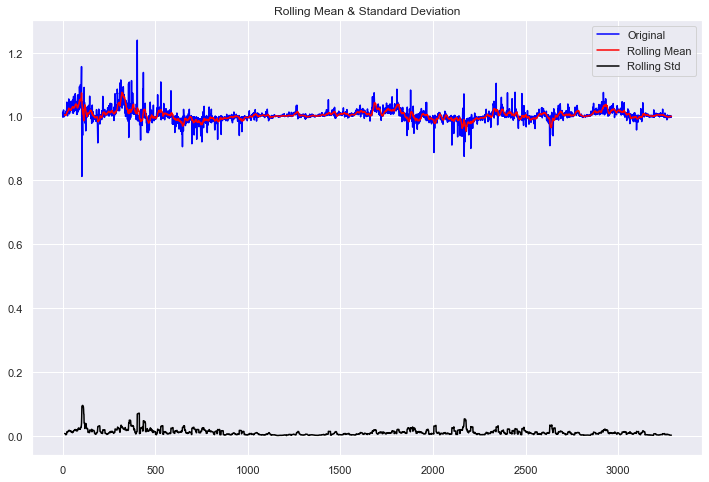

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -5.610644
p-value                           0.000001
#Lags Used                       16.000000
Number of Observations Used    3271.000000
Critical Value (1%)              -3.432351
Critical Value (5%)              -2.862424
Critical Value (10%)             -2.567241
dtype: float64


In [36]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is lower than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

The time series is stationary

SEBBENE LA SERIE SIA STAZIONARIA, DIFFERENZIO UGUALMENTE, PERCHE' PLOTTANDO ACF E PACF DELLA SERIE NON DIFFERENZIATA, LE SPIKE NON DECRESCEVANO VELOCEMENTE (TIPICO DELLE SERIE NON STAZIONARIE) (PER VEDERE FARE PROVA GIU')

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [41]:
# Get the difference of each Adj Close point
SOPR_diff_1 = series.diff()
SOPR_diff_1.dropna(inplace=True)

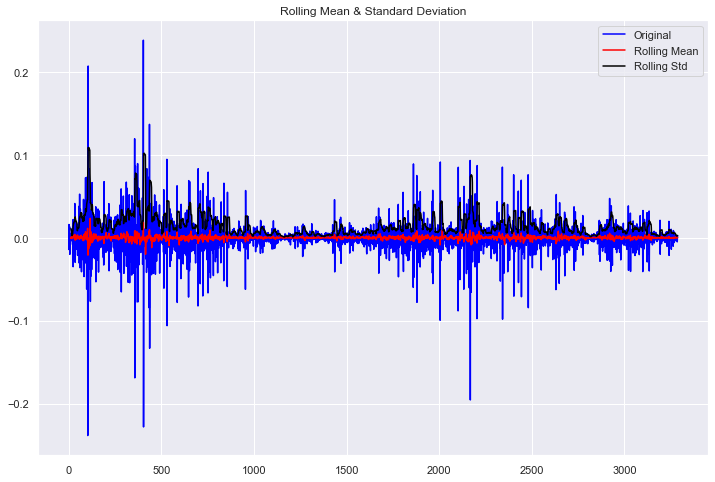

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -23.027611
p-value                           0.000000
#Lags Used                       15.000000
Number of Observations Used    3271.000000
Critical Value (1%)              -3.432351
Critical Value (5%)              -2.862424
Critical Value (10%)             -2.567241
dtype: float64


In [42]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(SOPR_diff_1)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We reject the null hypothesis. So, the time series is in fact stationary.

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

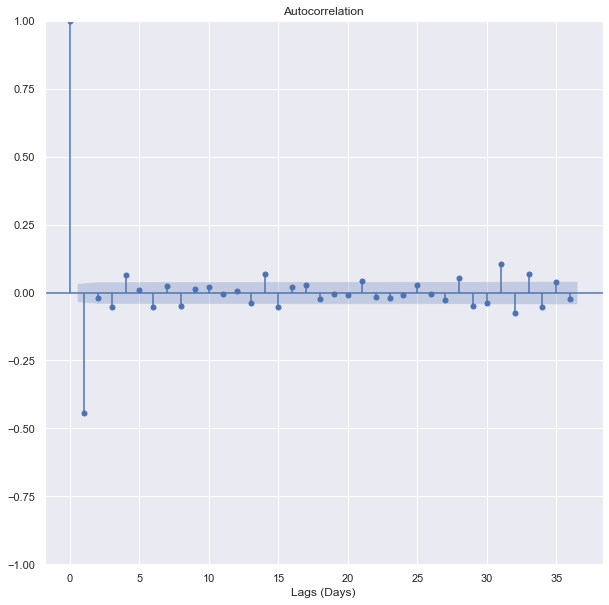

In [43]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(SOPR_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


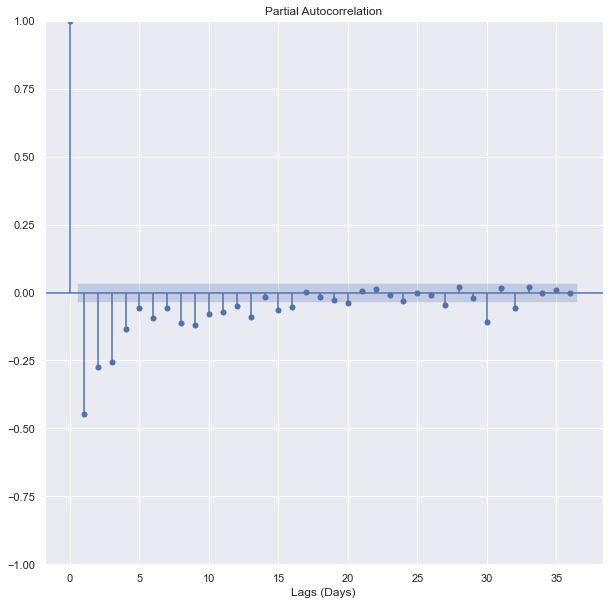

In [44]:
plot_pacf(SOPR_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

Mi aspetto un modello (1,1,3) o simile...

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-15701.179, Time=6.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-14435.715, Time=0.51 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-15071.385, Time=1.52 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-15671.496, Time=6.47 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-14437.714, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-15699.578, Time=3.25 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-15699.289, Time=6.23 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=-15669.339, Time=6.49 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-15679.920, Time=5.71 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=-15705.044, Time=12.30 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=-15692.311, Time=12.85 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=-15669.219, Time=7.22 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-15675.888, Time=11.75 sec
 ARIMA(1,1,0)(1,0,2)[7] in

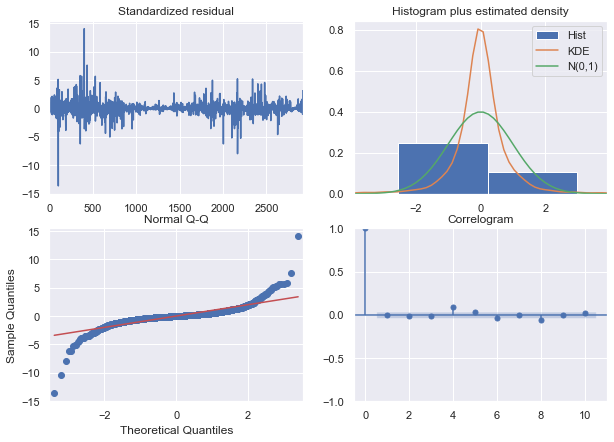

In [45]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(3,1,1)(0,0,2)[7]. Quindi ancora devo studiare la seasonality per capire se trovo qualche valore migliore, e in caso aggiungere sotto.

In [48]:
import statsmodels.api as sm

# fit model
SOPR_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,1), seasonal_order=(0,0,2,7))
SOPR_arima_fit = SOPR_arima.fit()
print(SOPR_arima_fit.summary())

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                 2923
Model:             ARIMA(3, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood                7864.622
Date:                              Mon, 10 Oct 2022   AIC                         -15715.243
Time:                                      22:27:18   BIC                         -15673.383
Sample:                                           0   HQIC                        -15700.166
                                             - 2923                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1730      0.010     16.750      0.000       0.153       0.193
ar.L2          0.06

NormaltestResult(statistic=6908.208885458815, pvalue=0.0)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


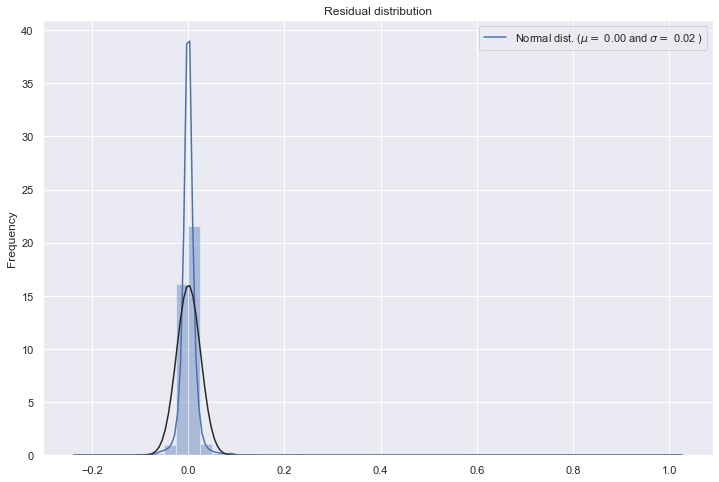

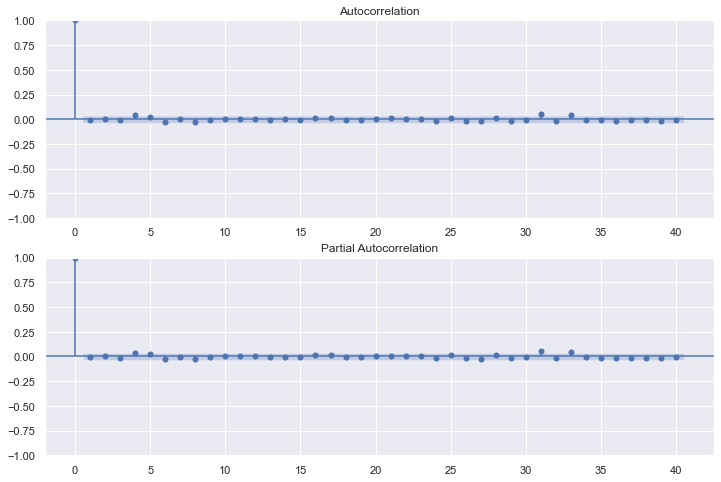

In [49]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = SOPR_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,1)(0,0,2,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

In [50]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 0.004289278340206155
Stored 'model_predictions' (list)


In [51]:
output

array([0.99961847])

In [52]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[1.0317710297239362,
 1.0261551091179733,
 1.0169593157130448,
 1.0145945085082746,
 1.0106201356314495]

In [53]:
model_predictions

[1.0317710297239362,
 1.0261551091179733,
 1.0169593157130448,
 1.0145945085082746,
 1.0106201356314495,
 1.0081585677125484,
 1.010614447636149,
 1.0101524117468816,
 1.0094244654913433,
 1.0082581516260651,
 1.0078772079999132,
 1.010601016507801,
 1.006347493793495,
 1.0041630922171145,
 1.0036308707706638,
 1.004158481096587,
 1.0024294844230723,
 1.0009431822903212,
 0.9994001746501865,
 1.000158944284,
 1.0074750015239322,
 1.0013983645638511,
 1.0017738731042496,
 1.0015564838385045,
 1.0020485121358151,
 0.997519057925559,
 0.9995118877775608,
 1.0000130019229914,
 1.0068999259312232,
 1.0046628495159005,
 1.0061829661571038,
 1.0152545912532926,
 1.0088365343497596,
 1.0087114352915612,
 1.004478534946413,
 1.0062650485187836,
 1.0051127979371415,
 1.004099119192372,
 1.0032726109392485,
 1.004502253578896,
 1.0041204717637833,
 1.0062270579999633,
 1.0055075024808329,
 1.0053787387124966,
 1.0083517562108328,
 1.0049939809476047,
 1.0047356448278033,
 1.0060094950048266,
 1.0

In [54]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.004620236002363955,
 'SMA 5': 0.003988186526800129,
 'ARIMA': 0.004289278340206155}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

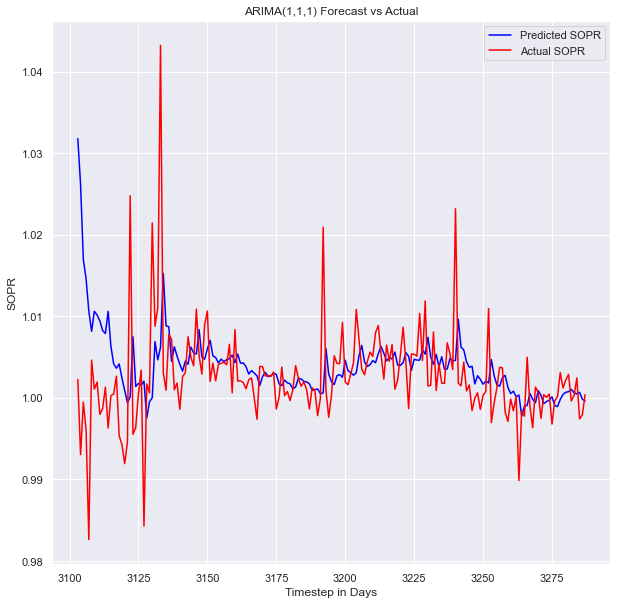

<Figure size 720x432 with 0 Axes>

In [55]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [56]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

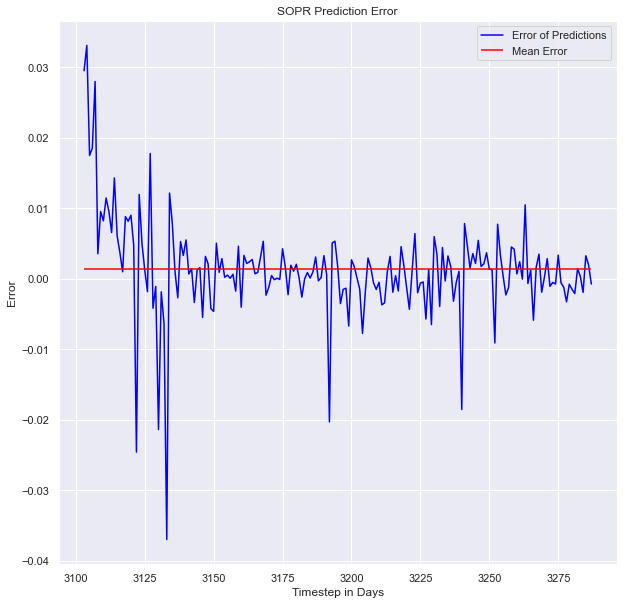

<Figure size 720x432 with 0 Axes>

In [57]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [58]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.004620236002363955,
 'SMA 5': 0.003988186526800129,
 'ARIMA': 0.004289278340206155}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

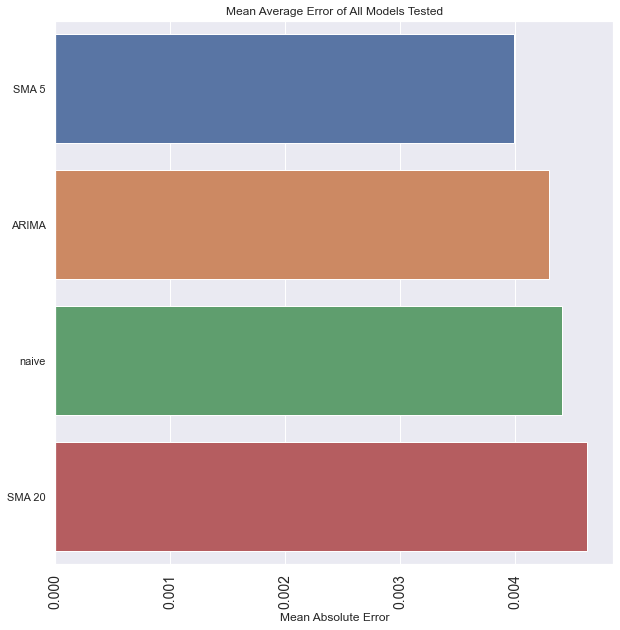

In [59]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [60]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [61]:
x_train

0       1.012306
1       0.998396
2       1.014277
3       0.999711
4       1.007465
          ...   
2918    1.018940
2919    1.028140
2920    1.075420
2921    1.053047
2922    1.024616
Name: Value, Length: 2923, dtype: float64

In [62]:
x_train.shape

(2923,)

In [63]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [64]:
x_train_values

array([[1.01230554],
       [0.99839607],
       [1.01427745],
       ...,
       [1.07542024],
       [1.0530466 ],
       [1.0246159 ]])

In [65]:
x_train_values.shape

(2923, 1)

In [66]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

In [67]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


146/146 [==============================] - 10s 18ms/step - loss: 0.0625 - mae: 0.3463 - lr: 1.0000e-05
Epoch 2/100
146/146 [==============================] - 3s 18ms/step - loss: 0.0111 - mae: 0.1233 - lr: 1.1220e-05
Epoch 3/100
146/146 [==============================] - 2s 16ms/step - loss: 0.0011 - mae: 0.0250 - lr: 1.2589e-05
Epoch 4/100
146/146 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0250 - lr: 1.4125e-05
Epoch 5/100
146/146 [==============================] - 3s 19ms/step - loss: 0.0011 - mae: 0.0251 - lr: 1.5849e-05
Epoch 6/100
146/146 [==============================] - 2s 14ms/step - loss: 0.0011 - mae: 0.0251 - lr: 1.7783e-05
Epoch 7/100
146/146 [==============================] - 3s 17ms/step - loss: 0.0011 - mae: 0.0252 - lr: 1.9953e-05
Epoch 8/100
146/146 [==============================] - 2s 17ms/step - loss: 0.0011 - mae: 0.0252 - lr: 2.2387e-05
Epoch 9/100
146/146 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0252 - 

146/146 [==============================] - 2s 17ms/step - loss: 0.0011 - mae: 0.0292 - lr: 0.0316
Epoch 72/100
146/146 [==============================] - 2s 16ms/step - loss: 0.0011 - mae: 0.0292 - lr: 0.0355
Epoch 73/100
146/146 [==============================] - 2s 16ms/step - loss: 0.0011 - mae: 0.0292 - lr: 0.0398
Epoch 74/100
146/146 [==============================] - 2s 16ms/step - loss: 0.0011 - mae: 0.0292 - lr: 0.0447
Epoch 75/100
146/146 [==============================] - 3s 18ms/step - loss: 0.0011 - mae: 0.0291 - lr: 0.0501
Epoch 76/100
146/146 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0289 - lr: 0.0562
Epoch 77/100
146/146 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0287 - lr: 0.0631
Epoch 78/100
146/146 [==============================] - 3s 18ms/step - loss: 0.0010 - mae: 0.0283 - lr: 0.0708
Epoch 79/100
146/146 [==============================] - 3s 17ms/step - loss: 0.0010 - mae: 0.0279 - lr: 0.0794
Epoch 80/100
1

(1e-05, 0.1, 0.0, 0.03)

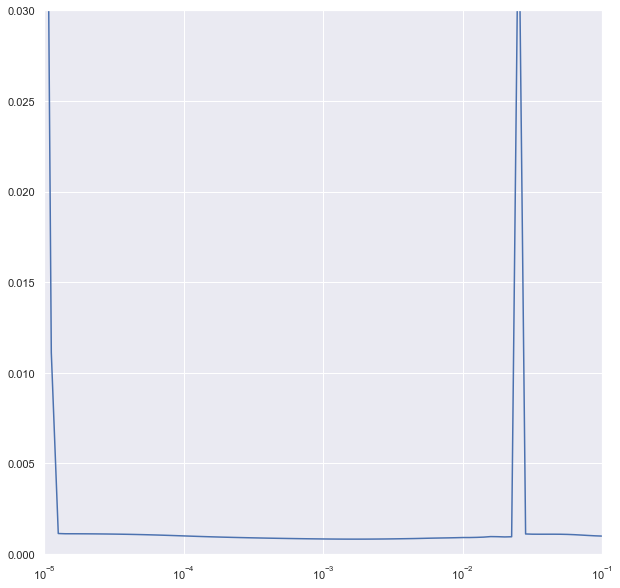

In [68]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [69]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00082

0.000822249916382134

In [70]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.00082)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     97/Unknown - 13s 24ms/step - loss: 0.0048 - mae: 0.0436

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 62s 530ms/step - loss: 0.0048 - mae: 0.0436 - val_loss: 3.6760e-04 - val_mae: 0.0207
Epoch 2/500
97/97 [==============================] - 3s 30ms/step - loss: 0.0012 - mae: 0.0273 - val_loss: 3.8344e-04 - val_mae: 0.0217
Epoch 3/500
97/97 [==============================] - 2s 22ms/step - loss: 0.0011 - mae: 0.0261 - val_loss: 3.9593e-04 - val_mae: 0.0224
Epoch 4/500
97/97 [==============================] - 2s 25ms/step - loss: 0.0010 - mae: 0.0253 - val_loss: 4.0171e-04 - val_mae: 0.0227
Epoch 5/500
97/97 [==============================] - 3s 27ms/step - loss: 9.7490e-04 - mae: 0.0248 - val_loss: 4.0308e-04 - val_mae: 0.0228
Epoch 6/500
97/97 [==============================] - 4s 38ms/step - loss: 9.4814e-04 - mae: 0.0244 - val_loss: 4.0166e-04 - val_mae: 0.0227
Epoch 7/500
97/97 [==============================] - 7s 68ms/step - loss: 9.2778e-04 - mae: 0.0242 - val_loss: 3.9858e-04 - val_mae: 0.0226
Epoch 8/500
97/97 [===========================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 38s 397ms/step - loss: 8.5054e-04 - mae: 0.0233 - val_loss: 3.6579e-04 - val_mae: 0.0211
Epoch 16/500
97/97 [==============================] - ETA: 0s - loss: 8.4530e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 365ms/step - loss: 8.4530e-04 - mae: 0.0233 - val_loss: 3.6261e-04 - val_mae: 0.0210
Epoch 17/500
95/97 [============================>.] - ETA: 0s - loss: 8.5195e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 36s 379ms/step - loss: 8.4053e-04 - mae: 0.0232 - val_loss: 3.5971e-04 - val_mae: 0.0208
Epoch 18/500
97/97 [==============================] - ETA: 0s - loss: 8.3618e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 38s 400ms/step - loss: 8.3618e-04 - mae: 0.0232 - val_loss: 3.5708e-04 - val_mae: 0.0207
Epoch 19/500
97/97 [==============================] - ETA: 0s - loss: 8.3223e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 34s 355ms/step - loss: 8.3223e-04 - mae: 0.0231 - val_loss: 3.5471e-04 - val_mae: 0.0206
Epoch 20/500
96/97 [============================>.] - ETA: 0s - loss: 8.3405e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 30s 315ms/step - loss: 8.2866e-04 - mae: 0.0231 - val_loss: 3.5259e-04 - val_mae: 0.0206
Epoch 21/500
96/97 [============================>.] - ETA: 0s - loss: 8.3083e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 48s 500ms/step - loss: 8.2547e-04 - mae: 0.0231 - val_loss: 3.5069e-04 - val_mae: 0.0205
Epoch 22/500
97/97 [==============================] - ETA: 0s - loss: 8.2264e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 39s 406ms/step - loss: 8.2264e-04 - mae: 0.0231 - val_loss: 3.4898e-04 - val_mae: 0.0204
Epoch 23/500
96/97 [============================>.] - ETA: 0s - loss: 8.2548e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 32s 328ms/step - loss: 8.2017e-04 - mae: 0.0231 - val_loss: 3.4744e-04 - val_mae: 0.0203
Epoch 24/500
97/97 [==============================] - ETA: 0s - loss: 8.1804e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 34s 356ms/step - loss: 8.1804e-04 - mae: 0.0231 - val_loss: 3.4605e-04 - val_mae: 0.0203
Epoch 25/500
95/97 [============================>.] - ETA: 0s - loss: 8.2738e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 30s 314ms/step - loss: 8.1622e-04 - mae: 0.0230 - val_loss: 3.4476e-04 - val_mae: 0.0202
Epoch 26/500
97/97 [==============================] - ETA: 0s - loss: 8.1469e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 361ms/step - loss: 8.1469e-04 - mae: 0.0230 - val_loss: 3.4357e-04 - val_mae: 0.0201
Epoch 27/500
95/97 [============================>.] - ETA: 0s - loss: 8.2454e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 36s 373ms/step - loss: 8.1340e-04 - mae: 0.0230 - val_loss: 3.4246e-04 - val_mae: 0.0201
Epoch 28/500
96/97 [============================>.] - ETA: 0s - loss: 8.1755e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 44s 457ms/step - loss: 8.1232e-04 - mae: 0.0230 - val_loss: 3.4141e-04 - val_mae: 0.0200
Epoch 29/500
95/97 [============================>.] - ETA: 0s - loss: 8.2255e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 47s 485ms/step - loss: 8.1140e-04 - mae: 0.0230 - val_loss: 3.4041e-04 - val_mae: 0.0200
Epoch 30/500
96/97 [============================>.] - ETA: 0s - loss: 8.1584e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 44s 460ms/step - loss: 8.1063e-04 - mae: 0.0230 - val_loss: 3.3946e-04 - val_mae: 0.0199
Epoch 31/500
96/97 [============================>.] - ETA: 0s - loss: 8.1516e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 362ms/step - loss: 8.0996e-04 - mae: 0.0230 - val_loss: 3.3855e-04 - val_mae: 0.0199
Epoch 32/500
97/97 [==============================] - ETA: 0s - loss: 8.0937e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 348ms/step - loss: 8.0937e-04 - mae: 0.0230 - val_loss: 3.3768e-04 - val_mae: 0.0198
Epoch 33/500
96/97 [============================>.] - ETA: 0s - loss: 8.1404e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 37s 387ms/step - loss: 8.0885e-04 - mae: 0.0230 - val_loss: 3.3685e-04 - val_mae: 0.0198
Epoch 34/500
97/97 [==============================] - ETA: 0s - loss: 8.0838e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 39s 404ms/step - loss: 8.0838e-04 - mae: 0.0230 - val_loss: 3.3604e-04 - val_mae: 0.0197
Epoch 35/500
94/97 [============================>.] - ETA: 0s - loss: 8.2754e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 41s 431ms/step - loss: 8.0794e-04 - mae: 0.0230 - val_loss: 3.3527e-04 - val_mae: 0.0197
Epoch 36/500
96/97 [============================>.] - ETA: 0s - loss: 8.1270e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 347ms/step - loss: 8.0753e-04 - mae: 0.0230 - val_loss: 3.3452e-04 - val_mae: 0.0196
Epoch 37/500
97/97 [==============================] - ETA: 0s - loss: 8.0714e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 29s 298ms/step - loss: 8.0714e-04 - mae: 0.0230 - val_loss: 3.3380e-04 - val_mae: 0.0196
Epoch 38/500
96/97 [============================>.] - ETA: 0s - loss: 8.1191e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 247ms/step - loss: 8.0675e-04 - mae: 0.0230 - val_loss: 3.3310e-04 - val_mae: 0.0195
Epoch 39/500
97/97 [==============================] - ETA: 0s - loss: 8.0638e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 296ms/step - loss: 8.0638e-04 - mae: 0.0230 - val_loss: 3.3242e-04 - val_mae: 0.0195
Epoch 40/500
96/97 [============================>.] - ETA: 0s - loss: 8.1115e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 36s 375ms/step - loss: 8.0600e-04 - mae: 0.0230 - val_loss: 3.3175e-04 - val_mae: 0.0195
Epoch 41/500
96/97 [============================>.] - ETA: 0s - loss: 8.1077e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 262ms/step - loss: 8.0563e-04 - mae: 0.0230 - val_loss: 3.3111e-04 - val_mae: 0.0194
Epoch 42/500
97/97 [==============================] - ETA: 0s - loss: 8.0525e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 31s 327ms/step - loss: 8.0525e-04 - mae: 0.0230 - val_loss: 3.3048e-04 - val_mae: 0.0194
Epoch 43/500
97/97 [==============================] - ETA: 0s - loss: 8.0486e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 361ms/step - loss: 8.0486e-04 - mae: 0.0230 - val_loss: 3.2986e-04 - val_mae: 0.0194
Epoch 44/500
96/97 [============================>.] - ETA: 0s - loss: 8.0960e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 34s 355ms/step - loss: 8.0447e-04 - mae: 0.0230 - val_loss: 3.2926e-04 - val_mae: 0.0193
Epoch 45/500
96/97 [============================>.] - ETA: 0s - loss: 8.0919e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 34s 357ms/step - loss: 8.0407e-04 - mae: 0.0230 - val_loss: 3.2867e-04 - val_mae: 0.0193
Epoch 46/500
97/97 [==============================] - ETA: 0s - loss: 8.0365e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 32s 336ms/step - loss: 8.0365e-04 - mae: 0.0230 - val_loss: 3.2809e-04 - val_mae: 0.0193
Epoch 47/500
94/97 [============================>.] - ETA: 0s - loss: 8.2284e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 296ms/step - loss: 8.0323e-04 - mae: 0.0230 - val_loss: 3.2752e-04 - val_mae: 0.0192
Epoch 48/500
95/97 [============================>.] - ETA: 0s - loss: 8.1409e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 30s 312ms/step - loss: 8.0280e-04 - mae: 0.0230 - val_loss: 3.2696e-04 - val_mae: 0.0192
Epoch 49/500
97/97 [==============================] - ETA: 0s - loss: 8.0235e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 54s 562ms/step - loss: 8.0235e-04 - mae: 0.0229 - val_loss: 3.2641e-04 - val_mae: 0.0192
Epoch 50/500
97/97 [==============================] - ETA: 0s - loss: 8.0189e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 31s 314ms/step - loss: 8.0189e-04 - mae: 0.0229 - val_loss: 3.2587e-04 - val_mae: 0.0191
Epoch 51/500
96/97 [============================>.] - ETA: 0s - loss: 8.0652e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 289ms/step - loss: 8.0141e-04 - mae: 0.0229 - val_loss: 3.2534e-04 - val_mae: 0.0191
Epoch 52/500
97/97 [==============================] - ETA: 0s - loss: 8.0092e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 263ms/step - loss: 8.0092e-04 - mae: 0.0229 - val_loss: 3.2483e-04 - val_mae: 0.0191
Epoch 53/500
94/97 [============================>.] - ETA: 0s - loss: 8.2001e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 262ms/step - loss: 8.0041e-04 - mae: 0.0229 - val_loss: 3.2432e-04 - val_mae: 0.0191
Epoch 54/500
97/97 [==============================] - ETA: 0s - loss: 7.9983e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 271ms/step - loss: 7.9983e-04 - mae: 0.0229 - val_loss: 3.2383e-04 - val_mae: 0.0191
Epoch 55/500
95/97 [============================>.] - ETA: 0s - loss: 8.1049e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 262ms/step - loss: 7.9917e-04 - mae: 0.0229 - val_loss: 3.2338e-04 - val_mae: 0.0190
Epoch 56/500
96/97 [============================>.] - ETA: 0s - loss: 8.0391e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 277ms/step - loss: 7.9882e-04 - mae: 0.0229 - val_loss: 3.2292e-04 - val_mae: 0.0190
Epoch 57/500
97/97 [==============================] - ETA: 0s - loss: 7.9836e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 29s 302ms/step - loss: 7.9836e-04 - mae: 0.0229 - val_loss: 3.2244e-04 - val_mae: 0.0190
Epoch 58/500
96/97 [============================>.] - ETA: 0s - loss: 8.0250e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 295ms/step - loss: 7.9741e-04 - mae: 0.0229 - val_loss: 3.2201e-04 - val_mae: 0.0190
Epoch 59/500
95/97 [============================>.] - ETA: 0s - loss: 8.0833e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 347ms/step - loss: 7.9700e-04 - mae: 0.0229 - val_loss: 3.2161e-04 - val_mae: 0.0190
Epoch 60/500
96/97 [============================>.] - ETA: 0s - loss: 8.0175e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 45s 464ms/step - loss: 7.9667e-04 - mae: 0.0229 - val_loss: 3.2118e-04 - val_mae: 0.0189
Epoch 61/500
95/97 [============================>.] - ETA: 0s - loss: 8.0733e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 42s 435ms/step - loss: 7.9600e-04 - mae: 0.0228 - val_loss: 3.2077e-04 - val_mae: 0.0189
Epoch 62/500
95/97 [============================>.] - ETA: 0s - loss: 8.0664e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 366ms/step - loss: 7.9532e-04 - mae: 0.0228 - val_loss: 3.2038e-04 - val_mae: 0.0189
Epoch 63/500
96/97 [============================>.] - ETA: 0s - loss: 7.9993e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 43s 449ms/step - loss: 7.9486e-04 - mae: 0.0228 - val_loss: 3.1998e-04 - val_mae: 0.0189
Epoch 64/500
97/97 [==============================] - ETA: 0s - loss: 7.9372e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 46s 475ms/step - loss: 7.9372e-04 - mae: 0.0228 - val_loss: 3.1971e-04 - val_mae: 0.0189
Epoch 65/500
96/97 [============================>.] - ETA: 0s - loss: 7.9849e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 39s 406ms/step - loss: 7.9343e-04 - mae: 0.0228 - val_loss: 3.1938e-04 - val_mae: 0.0189
Epoch 66/500
96/97 [============================>.] - ETA: 0s - loss: 7.9790e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 47s 488ms/step - loss: 7.9284e-04 - mae: 0.0228 - val_loss: 3.1906e-04 - val_mae: 0.0189
Epoch 67/500
97/97 [==============================] - ETA: 0s - loss: 7.9247e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 34s 350ms/step - loss: 7.9247e-04 - mae: 0.0228 - val_loss: 3.1866e-04 - val_mae: 0.0189
Epoch 68/500
97/97 [==============================] - ETA: 0s - loss: 7.9169e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 39s 408ms/step - loss: 7.9169e-04 - mae: 0.0228 - val_loss: 3.1829e-04 - val_mae: 0.0189
Epoch 69/500
95/97 [============================>.] - ETA: 0s - loss: 8.0255e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 32s 332ms/step - loss: 7.9123e-04 - mae: 0.0228 - val_loss: 3.1806e-04 - val_mae: 0.0189
Epoch 70/500
96/97 [============================>.] - ETA: 0s - loss: 7.9582e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 274ms/step - loss: 7.9077e-04 - mae: 0.0228 - val_loss: 3.1781e-04 - val_mae: 0.0188
Epoch 71/500
97/97 [==============================] - ETA: 0s - loss: 7.8966e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 32s 330ms/step - loss: 7.8966e-04 - mae: 0.0227 - val_loss: 3.1743e-04 - val_mae: 0.0188
Epoch 72/500
97/97 [==============================] - ETA: 0s - loss: 7.8833e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 256ms/step - loss: 7.8833e-04 - mae: 0.0227 - val_loss: 3.1729e-04 - val_mae: 0.0188
Epoch 73/500
96/97 [============================>.] - ETA: 0s - loss: 7.9363e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 232ms/step - loss: 7.8858e-04 - mae: 0.0227 - val_loss: 3.1696e-04 - val_mae: 0.0188
Epoch 74/500
96/97 [============================>.] - ETA: 0s - loss: 7.9276e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 251ms/step - loss: 7.8772e-04 - mae: 0.0227 - val_loss: 3.1669e-04 - val_mae: 0.0188
Epoch 75/500
95/97 [============================>.] - ETA: 0s - loss: 7.9905e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 239ms/step - loss: 7.8776e-04 - mae: 0.0227 - val_loss: 3.1644e-04 - val_mae: 0.0188
Epoch 76/500
96/97 [============================>.] - ETA: 0s - loss: 7.9169e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 29s 298ms/step - loss: 7.8665e-04 - mae: 0.0227 - val_loss: 3.1626e-04 - val_mae: 0.0188
Epoch 77/500
97/97 [==============================] - ETA: 0s - loss: 7.8613e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 270ms/step - loss: 7.8613e-04 - mae: 0.0227 - val_loss: 3.1607e-04 - val_mae: 0.0188
Epoch 78/500
95/97 [============================>.] - ETA: 0s - loss: 7.9625e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 276ms/step - loss: 7.8495e-04 - mae: 0.0227 - val_loss: 3.1585e-04 - val_mae: 0.0188
Epoch 79/500
96/97 [============================>.] - ETA: 0s - loss: 7.8964e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 277ms/step - loss: 7.8461e-04 - mae: 0.0227 - val_loss: 3.1575e-04 - val_mae: 0.0188
Epoch 80/500
95/97 [============================>.] - ETA: 0s - loss: 7.9506e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 259ms/step - loss: 7.8377e-04 - mae: 0.0226 - val_loss: 3.1566e-04 - val_mae: 0.0188
Epoch 81/500
97/97 [==============================] - ETA: 0s - loss: 7.8379e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 286ms/step - loss: 7.8379e-04 - mae: 0.0226 - val_loss: 3.1540e-04 - val_mae: 0.0188
Epoch 82/500
95/97 [============================>.] - ETA: 0s - loss: 7.9417e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 248ms/step - loss: 7.8290e-04 - mae: 0.0226 - val_loss: 3.1520e-04 - val_mae: 0.0188
Epoch 83/500
97/97 [==============================] - ETA: 0s - loss: 7.8166e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 50s 523ms/step - loss: 7.8166e-04 - mae: 0.0226 - val_loss: 3.1498e-04 - val_mae: 0.0188
Epoch 84/500
96/97 [============================>.] - ETA: 0s - loss: 7.8662e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 36s 378ms/step - loss: 7.8160e-04 - mae: 0.0226 - val_loss: 3.1482e-04 - val_mae: 0.0188
Epoch 85/500
95/97 [============================>.] - ETA: 0s - loss: 7.9186e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 360ms/step - loss: 7.8060e-04 - mae: 0.0226 - val_loss: 3.1480e-04 - val_mae: 0.0188
Epoch 86/500
97/97 [==============================] - ETA: 0s - loss: 7.7958e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 53s 556ms/step - loss: 7.7958e-04 - mae: 0.0226 - val_loss: 3.1466e-04 - val_mae: 0.0188
Epoch 87/500
96/97 [============================>.] - ETA: 0s - loss: 7.8474e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 38s 396ms/step - loss: 7.7973e-04 - mae: 0.0226 - val_loss: 3.1435e-04 - val_mae: 0.0188
Epoch 88/500
97/97 [==============================] - ETA: 0s - loss: 7.7832e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 347ms/step - loss: 7.7832e-04 - mae: 0.0225 - val_loss: 3.1434e-04 - val_mae: 0.0188
Epoch 89/500
96/97 [============================>.] - ETA: 0s - loss: 7.8306e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 367ms/step - loss: 7.7805e-04 - mae: 0.0225 - val_loss: 3.1413e-04 - val_mae: 0.0188
Epoch 90/500
97/97 [==============================] - ETA: 0s - loss: 7.7762e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 46s 479ms/step - loss: 7.7762e-04 - mae: 0.0225 - val_loss: 3.1391e-04 - val_mae: 0.0188
Epoch 91/500
97/97 [==============================] - ETA: 0s - loss: 7.7687e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 265ms/step - loss: 7.7687e-04 - mae: 0.0225 - val_loss: 3.1373e-04 - val_mae: 0.0188
Epoch 92/500
97/97 [==============================] - ETA: 0s - loss: 7.7600e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 14416s 150s/step - loss: 7.7600e-04 - mae: 0.0225 - val_loss: 3.1356e-04 - val_mae: 0.0188
Epoch 93/500
97/97 [==============================] - ETA: 0s - loss: 7.7507e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 17252s 180s/step - loss: 7.7507e-04 - mae: 0.0225 - val_loss: 3.1345e-04 - val_mae: 0.0188
Epoch 94/500
97/97 [==============================] - ETA: 0s - loss: 7.7490e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 7.7490e-04 - mae: 0.0225 - val_loss: 3.1316e-04 - val_mae: 0.0188
Epoch 95/500
96/97 [============================>.] - ETA: 20s - loss: 7.7879e-04 - mae: 0.0225 

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 1997s 21s/step - loss: 7.7379e-04 - mae: 0.0225 - val_loss: 3.1305e-04 - val_mae: 0.0188
Epoch 96/500
95/97 [============================>.] - ETA: 0s - loss: 7.8493e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 362ms/step - loss: 7.7375e-04 - mae: 0.0225 - val_loss: 3.1278e-04 - val_mae: 0.0188
Epoch 97/500
96/97 [============================>.] - ETA: 0s - loss: 7.7799e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 345ms/step - loss: 7.7301e-04 - mae: 0.0225 - val_loss: 3.1267e-04 - val_mae: 0.0188
Epoch 98/500
97/97 [==============================] - ETA: 0s - loss: 7.7239e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 36s 372ms/step - loss: 7.7239e-04 - mae: 0.0224 - val_loss: 3.1258e-04 - val_mae: 0.0188
Epoch 99/500
96/97 [============================>.] - ETA: 0s - loss: 7.7680e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 365ms/step - loss: 7.7182e-04 - mae: 0.0224 - val_loss: 3.1239e-04 - val_mae: 0.0188
Epoch 100/500
97/97 [==============================] - ETA: 0s - loss: 7.7166e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 32s 330ms/step - loss: 7.7166e-04 - mae: 0.0224 - val_loss: 3.1210e-04 - val_mae: 0.0188
Epoch 101/500
94/97 [============================>.] - ETA: 0s - loss: 7.9005e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 279ms/step - loss: 7.7082e-04 - mae: 0.0224 - val_loss: 3.1188e-04 - val_mae: 0.0188
Epoch 102/500
95/97 [============================>.] - ETA: 0s - loss: 7.8196e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 219ms/step - loss: 7.7085e-04 - mae: 0.0224 - val_loss: 3.1152e-04 - val_mae: 0.0187
Epoch 103/500
97/97 [==============================] - ETA: 0s - loss: 7.6986e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 256ms/step - loss: 7.6986e-04 - mae: 0.0224 - val_loss: 3.1131e-04 - val_mae: 0.0187
Epoch 104/500
97/97 [==============================] - ETA: 0s - loss: 7.6959e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 280ms/step - loss: 7.6959e-04 - mae: 0.0224 - val_loss: 3.1106e-04 - val_mae: 0.0187
Epoch 105/500
97/97 [==============================] - ETA: 0s - loss: 7.6903e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 30s 310ms/step - loss: 7.6903e-04 - mae: 0.0224 - val_loss: 3.1071e-04 - val_mae: 0.0187
Epoch 106/500
95/97 [============================>.] - ETA: 0s - loss: 7.7978e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 277ms/step - loss: 7.6871e-04 - mae: 0.0224 - val_loss: 3.1045e-04 - val_mae: 0.0187
Epoch 107/500
97/97 [==============================] - ETA: 0s - loss: 7.6791e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 36s 375ms/step - loss: 7.6791e-04 - mae: 0.0224 - val_loss: 3.1023e-04 - val_mae: 0.0187
Epoch 108/500
97/97 [==============================] - ETA: 0s - loss: 7.6747e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 38s 396ms/step - loss: 7.6747e-04 - mae: 0.0224 - val_loss: 3.0999e-04 - val_mae: 0.0187
Epoch 109/500
97/97 [==============================] - ETA: 0s - loss: 7.6664e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 29s 297ms/step - loss: 7.6664e-04 - mae: 0.0224 - val_loss: 3.0970e-04 - val_mae: 0.0187
Epoch 110/500
97/97 [==============================] - ETA: 0s - loss: 7.6599e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 272ms/step - loss: 7.6599e-04 - mae: 0.0224 - val_loss: 3.0937e-04 - val_mae: 0.0187
Epoch 111/500
94/97 [============================>.] - ETA: 0s - loss: 7.8509e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 237ms/step - loss: 7.6597e-04 - mae: 0.0224 - val_loss: 3.0907e-04 - val_mae: 0.0187
Epoch 112/500
95/97 [============================>.] - ETA: 0s - loss: 7.7590e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 253ms/step - loss: 7.6483e-04 - mae: 0.0224 - val_loss: 3.0891e-04 - val_mae: 0.0187
Epoch 113/500
97/97 [==============================] - ETA: 0s - loss: 7.6454e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 282ms/step - loss: 7.6454e-04 - mae: 0.0224 - val_loss: 3.0880e-04 - val_mae: 0.0187
Epoch 114/500
97/97 [==============================] - ETA: 0s - loss: 7.6393e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 243ms/step - loss: 7.6393e-04 - mae: 0.0224 - val_loss: 3.0849e-04 - val_mae: 0.0186
Epoch 115/500
96/97 [============================>.] - ETA: 0s - loss: 7.6831e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 260ms/step - loss: 7.6336e-04 - mae: 0.0224 - val_loss: 3.0830e-04 - val_mae: 0.0186
Epoch 116/500
95/97 [============================>.] - ETA: 0s - loss: 7.7358e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 265ms/step - loss: 7.6258e-04 - mae: 0.0224 - val_loss: 3.0818e-04 - val_mae: 0.0186
Epoch 117/500
94/97 [============================>.] - ETA: 0s - loss: 7.8055e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 342ms/step - loss: 7.6152e-04 - mae: 0.0224 - val_loss: 3.0815e-04 - val_mae: 0.0186
Epoch 118/500
96/97 [============================>.] - ETA: 0s - loss: 7.6593e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 364ms/step - loss: 7.6099e-04 - mae: 0.0224 - val_loss: 3.0810e-04 - val_mae: 0.0186
Epoch 119/500
97/97 [==============================] - 2s 18ms/step - loss: 7.6013e-04 - mae: 0.0224 - val_loss: 3.0816e-04 - val_mae: 0.0186
Epoch 120/500
97/97 [==============================] - 2s 17ms/step - loss: 7.5938e-04 - mae: 0.0224 - val_loss: 3.0816e-04 - val_mae: 0.0186
Epoch 121/500
97/97 [==============================] - 2s 16ms/step - loss: 7.5847e-04 - mae: 0.0224 - val_loss: 3.0815e-04 - val_mae: 0.0187
Epoch 122/500
97/97 [==============================] - ETA: 0s - loss: 7.5802e-04 - mae: 0.0223

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 256ms/step - loss: 7.5802e-04 - mae: 0.0223 - val_loss: 3.0810e-04 - val_mae: 0.0186
Epoch 123/500
96/97 [============================>.] - ETA: 0s - loss: 7.6210e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 238ms/step - loss: 7.5719e-04 - mae: 0.0223 - val_loss: 3.0807e-04 - val_mae: 0.0186
Epoch 124/500
95/97 [============================>.] - ETA: 0s - loss: 7.6718e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 247ms/step - loss: 7.5629e-04 - mae: 0.0223 - val_loss: 3.0804e-04 - val_mae: 0.0186
Epoch 125/500
95/97 [============================>.] - ETA: 0s - loss: 7.6650e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.5563e-04 - mae: 0.0223 - val_loss: 3.0798e-04 - val_mae: 0.0186
Epoch 126/500
95/97 [============================>.] - ETA: 0s - loss: 7.6572e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 7.5487e-04 - mae: 0.0223 - val_loss: 3.0788e-04 - val_mae: 0.0186
Epoch 127/500
97/97 [==============================] - ETA: 0s - loss: 7.5414e-04 - mae: 0.0223

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.5414e-04 - mae: 0.0223 - val_loss: 3.0775e-04 - val_mae: 0.0186
Epoch 128/500
95/97 [============================>.] - ETA: 0s - loss: 7.6417e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.5338e-04 - mae: 0.0223 - val_loss: 3.0755e-04 - val_mae: 0.0186
Epoch 129/500
95/97 [============================>.] - ETA: 0s - loss: 7.6332e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.5254e-04 - mae: 0.0223 - val_loss: 3.0727e-04 - val_mae: 0.0186
Epoch 130/500
97/97 [==============================] - ETA: 0s - loss: 7.5156e-04 - mae: 0.0223

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 244ms/step - loss: 7.5156e-04 - mae: 0.0223 - val_loss: 3.0696e-04 - val_mae: 0.0186
Epoch 131/500
96/97 [============================>.] - ETA: 0s - loss: 7.5544e-04 - mae: 0.0223

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.5060e-04 - mae: 0.0222 - val_loss: 3.0672e-04 - val_mae: 0.0186
Epoch 132/500
97/97 [==============================] - ETA: 0s - loss: 7.4994e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 7.4994e-04 - mae: 0.0222 - val_loss: 3.0656e-04 - val_mae: 0.0186
Epoch 133/500
95/97 [============================>.] - ETA: 0s - loss: 7.5977e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 258ms/step - loss: 7.4909e-04 - mae: 0.0222 - val_loss: 3.0637e-04 - val_mae: 0.0185
Epoch 134/500
97/97 [==============================] - ETA: 0s - loss: 7.4825e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 275ms/step - loss: 7.4825e-04 - mae: 0.0222 - val_loss: 3.0617e-04 - val_mae: 0.0185
Epoch 135/500
94/97 [============================>.] - ETA: 0s - loss: 7.6601e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 289ms/step - loss: 7.4744e-04 - mae: 0.0222 - val_loss: 3.0603e-04 - val_mae: 0.0185
Epoch 136/500
97/97 [==============================] - ETA: 0s - loss: 7.4624e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 258ms/step - loss: 7.4624e-04 - mae: 0.0222 - val_loss: 3.0578e-04 - val_mae: 0.0185
Epoch 137/500
96/97 [============================>.] - ETA: 0s - loss: 7.4995e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 280ms/step - loss: 7.4520e-04 - mae: 0.0222 - val_loss: 3.0565e-04 - val_mae: 0.0185
Epoch 138/500
97/97 [==============================] - ETA: 0s - loss: 7.4412e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 251ms/step - loss: 7.4412e-04 - mae: 0.0222 - val_loss: 3.0546e-04 - val_mae: 0.0185
Epoch 139/500
97/97 [==============================] - ETA: 0s - loss: 7.4313e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 30s 308ms/step - loss: 7.4313e-04 - mae: 0.0222 - val_loss: 3.0532e-04 - val_mae: 0.0185
Epoch 140/500
96/97 [============================>.] - ETA: 0s - loss: 7.4673e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 243ms/step - loss: 7.4204e-04 - mae: 0.0222 - val_loss: 3.0513e-04 - val_mae: 0.0185
Epoch 141/500
96/97 [============================>.] - ETA: 0s - loss: 7.4572e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 31s 322ms/step - loss: 7.4104e-04 - mae: 0.0222 - val_loss: 3.0508e-04 - val_mae: 0.0185
Epoch 142/500
97/97 [==============================] - ETA: 0s - loss: 7.3983e-04 - mae: 0.0221

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 253ms/step - loss: 7.3983e-04 - mae: 0.0221 - val_loss: 3.0507e-04 - val_mae: 0.0185
Epoch 143/500
97/97 [==============================] - 1s 15ms/step - loss: 7.3847e-04 - mae: 0.0221 - val_loss: 3.0522e-04 - val_mae: 0.0185
Epoch 144/500
97/97 [==============================] - 2s 16ms/step - loss: 7.3718e-04 - mae: 0.0221 - val_loss: 3.0538e-04 - val_mae: 0.0185
Epoch 145/500
97/97 [==============================] - 2s 16ms/step - loss: 7.3599e-04 - mae: 0.0221 - val_loss: 3.0557e-04 - val_mae: 0.0185
Epoch 146/500
97/97 [==============================] - 2s 16ms/step - loss: 7.3450e-04 - mae: 0.0221 - val_loss: 3.0548e-04 - val_mae: 0.0185
Epoch 147/500
97/97 [==============================] - 2s 17ms/step - loss: 7.3362e-04 - mae: 0.0221 - val_loss: 3.0563e-04 - val_mae: 0.0185
Epoch 148/500
97/97 [==============================] - 1s 15ms/step - loss: 7.3238e-04 - mae: 0.0221 - val_loss: 3.0579e-04 - val_mae: 0.0185
Epoch 149/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 236ms/step - loss: 7.1843e-04 - mae: 0.0221 - val_loss: 3.0486e-04 - val_mae: 0.0184
Epoch 158/500
94/97 [============================>.] - ETA: 0s - loss: 7.3424e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.1680e-04 - mae: 0.0221 - val_loss: 3.0459e-04 - val_mae: 0.0184
Epoch 159/500
97/97 [==============================] - ETA: 0s - loss: 7.1503e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 221ms/step - loss: 7.1503e-04 - mae: 0.0220 - val_loss: 3.0376e-04 - val_mae: 0.0184
Epoch 160/500
97/97 [==============================] - ETA: 0s - loss: 7.1364e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 223ms/step - loss: 7.1364e-04 - mae: 0.0220 - val_loss: 3.0314e-04 - val_mae: 0.0184
Epoch 161/500
97/97 [==============================] - ETA: 0s - loss: 7.1196e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 226ms/step - loss: 7.1196e-04 - mae: 0.0220 - val_loss: 3.0221e-04 - val_mae: 0.0184
Epoch 162/500
97/97 [==============================] - ETA: 0s - loss: 7.1070e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 224ms/step - loss: 7.1070e-04 - mae: 0.0220 - val_loss: 3.0166e-04 - val_mae: 0.0183
Epoch 163/500
97/97 [==============================] - ETA: 0s - loss: 7.0906e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 219ms/step - loss: 7.0906e-04 - mae: 0.0220 - val_loss: 3.0119e-04 - val_mae: 0.0183
Epoch 164/500
97/97 [==============================] - ETA: 0s - loss: 7.0823e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 223ms/step - loss: 7.0823e-04 - mae: 0.0220 - val_loss: 3.0056e-04 - val_mae: 0.0183
Epoch 165/500
96/97 [============================>.] - ETA: 0s - loss: 7.1120e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 219ms/step - loss: 7.0692e-04 - mae: 0.0219 - val_loss: 3.0023e-04 - val_mae: 0.0183
Epoch 166/500
95/97 [============================>.] - ETA: 0s - loss: 7.1695e-04 - mae: 0.0221

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 7.0743e-04 - mae: 0.0220 - val_loss: 2.9945e-04 - val_mae: 0.0182
Epoch 167/500
94/97 [============================>.] - ETA: 0s - loss: 7.2330e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 256ms/step - loss: 7.0630e-04 - mae: 0.0219 - val_loss: 2.9912e-04 - val_mae: 0.0182
Epoch 168/500
95/97 [============================>.] - ETA: 0s - loss: 7.1358e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 219ms/step - loss: 7.0408e-04 - mae: 0.0218 - val_loss: 2.9791e-04 - val_mae: 0.0182
Epoch 169/500
97/97 [==============================] - 2s 15ms/step - loss: 7.0381e-04 - mae: 0.0219 - val_loss: 2.9965e-04 - val_mae: 0.0183
Epoch 170/500
97/97 [==============================] - 1s 15ms/step - loss: 7.0012e-04 - mae: 0.0219 - val_loss: 2.9961e-04 - val_mae: 0.0183
Epoch 171/500
97/97 [==============================] - 2s 16ms/step - loss: 7.1433e-04 - mae: 0.0222 - val_loss: 3.0060e-04 - val_mae: 0.0182
Epoch 172/500
95/97 [============================>.] - ETA: 0s - loss: 7.2566e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 7.1532e-04 - mae: 0.0219 - val_loss: 2.9455e-04 - val_mae: 0.0186
Epoch 173/500
97/97 [==============================] - ETA: 0s - loss: 7.0412e-04 - mae: 0.0216

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 259ms/step - loss: 7.0412e-04 - mae: 0.0216 - val_loss: 2.9426e-04 - val_mae: 0.0183
Epoch 174/500
97/97 [==============================] - 4s 38ms/step - loss: 6.9705e-04 - mae: 0.0216 - val_loss: 2.9633e-04 - val_mae: 0.0182
Epoch 175/500
97/97 [==============================] - 2s 25ms/step - loss: 6.9406e-04 - mae: 0.0216 - val_loss: 2.9836e-04 - val_mae: 0.0183
Epoch 176/500
97/97 [==============================] - 2s 22ms/step - loss: 6.9233e-04 - mae: 0.0216 - val_loss: 2.9925e-04 - val_mae: 0.0183
Epoch 177/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9286e-04 - mae: 0.0217 - val_loss: 3.0021e-04 - val_mae: 0.0184
Epoch 178/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9119e-04 - mae: 0.0217 - val_loss: 2.9791e-04 - val_mae: 0.0182
Epoch 179/500
97/97 [==============================] - 2s 17ms/step - loss: 6.9459e-04 - mae: 0.0217 - val_loss: 2.9808e-04 - val_mae: 0.0183
Epoch 180/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 258ms/step - loss: 6.8838e-04 - mae: 0.0215 - val_loss: 2.9358e-04 - val_mae: 0.0181
Epoch 181/500
97/97 [==============================] - 2s 19ms/step - loss: 7.0524e-04 - mae: 0.0218 - val_loss: 2.9619e-04 - val_mae: 0.0181
Epoch 182/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9591e-04 - mae: 0.0217 - val_loss: 2.9857e-04 - val_mae: 0.0182
Epoch 183/500
97/97 [==============================] - 2s 23ms/step - loss: 6.9138e-04 - mae: 0.0217 - val_loss: 2.9861e-04 - val_mae: 0.0183
Epoch 184/500
97/97 [==============================] - 3s 26ms/step - loss: 6.8723e-04 - mae: 0.0216 - val_loss: 2.9727e-04 - val_mae: 0.0183
Epoch 185/500
97/97 [==============================] - 2s 22ms/step - loss: 6.8850e-04 - mae: 0.0216 - val_loss: 2.9592e-04 - val_mae: 0.0182
Epoch 186/500
97/97 [==============================] - 2s 23ms/step - loss: 6.8504e-04 - mae: 0.0216 - val_loss: 2.9471e-04 - val_mae: 0.0182
Epoch 187/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 288ms/step - loss: 6.8194e-04 - mae: 0.0215 - val_loss: 2.9314e-04 - val_mae: 0.0182
Epoch 192/500
97/97 [==============================] - 2s 16ms/step - loss: 6.7914e-04 - mae: 0.0214 - val_loss: 2.9329e-04 - val_mae: 0.0182
Epoch 193/500
97/97 [==============================] - 2s 17ms/step - loss: 6.9736e-04 - mae: 0.0218 - val_loss: 2.9649e-04 - val_mae: 0.0185
Epoch 194/500
94/97 [============================>.] - ETA: 0s - loss: 7.0299e-04 - mae: 0.0219

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 290ms/step - loss: 6.8641e-04 - mae: 0.0216 - val_loss: 2.9307e-04 - val_mae: 0.0184
Epoch 195/500
97/97 [==============================] - 2s 22ms/step - loss: 6.7810e-04 - mae: 0.0215 - val_loss: 2.9428e-04 - val_mae: 0.0181
Epoch 196/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9797e-04 - mae: 0.0217 - val_loss: 2.9609e-04 - val_mae: 0.0182
Epoch 197/500
97/97 [==============================] - 2s 21ms/step - loss: 6.7700e-04 - mae: 0.0215 - val_loss: 2.9393e-04 - val_mae: 0.0181
Epoch 198/500
97/97 [==============================] - 2s 17ms/step - loss: 6.9173e-04 - mae: 0.0217 - val_loss: 2.9714e-04 - val_mae: 0.0183
Epoch 199/500
97/97 [==============================] - 2s 18ms/step - loss: 6.7263e-04 - mae: 0.0215 - val_loss: 2.9399e-04 - val_mae: 0.0182
Epoch 200/500
97/97 [==============================] - 2s 16ms/step - loss: 6.9597e-04 - mae: 0.0217 - val_loss: 2.9440e-04 - val_mae: 0.0181
Epoch 201/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 253ms/step - loss: 6.8426e-04 - mae: 0.0216 - val_loss: 2.9182e-04 - val_mae: 0.0181
Epoch 209/500
97/97 [==============================] - ETA: 0s - loss: 6.8113e-04 - mae: 0.0216

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 35s 363ms/step - loss: 6.8113e-04 - mae: 0.0216 - val_loss: 2.9113e-04 - val_mae: 0.0181
Epoch 210/500
97/97 [==============================] - 2s 22ms/step - loss: 6.7904e-04 - mae: 0.0216 - val_loss: 2.9217e-04 - val_mae: 0.0182
Epoch 211/500
97/97 [==============================] - 2s 19ms/step - loss: 6.7692e-04 - mae: 0.0216 - val_loss: 2.9284e-04 - val_mae: 0.0182
Epoch 212/500
97/97 [==============================] - 2s 19ms/step - loss: 6.7463e-04 - mae: 0.0216 - val_loss: 2.9210e-04 - val_mae: 0.0182
Epoch 213/500
97/97 [==============================] - 2s 19ms/step - loss: 6.7685e-04 - mae: 0.0216 - val_loss: 2.9466e-04 - val_mae: 0.0183
Epoch 214/500
97/97 [==============================] - 2s 19ms/step - loss: 6.8015e-04 - mae: 0.0217 - val_loss: 2.9396e-04 - val_mae: 0.0183
Epoch 215/500
97/97 [==============================] - 3s 28ms/step - loss: 6.7315e-04 - mae: 0.0215 - val_loss: 2.9684e-04 - val_mae: 0.0184
Epoch 216/500
96/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 33s 339ms/step - loss: 6.6631e-04 - mae: 0.0215 - val_loss: 2.9025e-04 - val_mae: 0.0182
Epoch 217/500
97/97 [==============================] - 2s 16ms/step - loss: 6.8114e-04 - mae: 0.0217 - val_loss: 2.9051e-04 - val_mae: 0.0183
Epoch 218/500
97/97 [==============================] - 2s 16ms/step - loss: 6.7763e-04 - mae: 0.0214 - val_loss: 2.9646e-04 - val_mae: 0.0184
Epoch 219/500
97/97 [==============================] - 2s 22ms/step - loss: 6.9530e-04 - mae: 0.0219 - val_loss: 2.9354e-04 - val_mae: 0.0182
Epoch 220/500
97/97 [==============================] - 2s 18ms/step - loss: 7.2327e-04 - mae: 0.0222 - val_loss: 2.9219e-04 - val_mae: 0.0180
Epoch 221/500
97/97 [==============================] - 2s 17ms/step - loss: 7.0176e-04 - mae: 0.0219 - val_loss: 2.9244e-04 - val_mae: 0.0180
Epoch 222/500
97/97 [==============================] - 2s 16ms/step - loss: 6.9084e-04 - mae: 0.0218 - val_loss: 2.9362e-04 - val_mae: 0.0181
Epoch 223/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 253ms/step - loss: 6.5590e-04 - mae: 0.0216 - val_loss: 2.8768e-04 - val_mae: 0.0180
Epoch 240/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6794e-04 - mae: 0.0215 - val_loss: 3.0018e-04 - val_mae: 0.0185
Epoch 241/500
97/97 [==============================] - 2s 20ms/step - loss: 6.8376e-04 - mae: 0.0219 - val_loss: 3.0583e-04 - val_mae: 0.0184
Epoch 242/500
97/97 [==============================] - 2s 19ms/step - loss: 7.0564e-04 - mae: 0.0219 - val_loss: 2.9822e-04 - val_mae: 0.0181
Epoch 243/500
97/97 [==============================] - 2s 20ms/step - loss: 6.7700e-04 - mae: 0.0216 - val_loss: 2.9966e-04 - val_mae: 0.0181
Epoch 244/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6287e-04 - mae: 0.0214 - val_loss: 2.9823e-04 - val_mae: 0.0182
Epoch 245/500
97/97 [==============================] - 2s 20ms/step - loss: 6.6215e-04 - mae: 0.0214 - val_loss: 2.9971e-04 - val_mae: 0.0183
Epoch 246/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 265ms/step - loss: 6.6875e-04 - mae: 0.0217 - val_loss: 2.8187e-04 - val_mae: 0.0177
Epoch 260/500
97/97 [==============================] - 2s 17ms/step - loss: 6.6027e-04 - mae: 0.0214 - val_loss: 2.8960e-04 - val_mae: 0.0178
Epoch 261/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6552e-04 - mae: 0.0214 - val_loss: 2.9045e-04 - val_mae: 0.0179
Epoch 262/500
97/97 [==============================] - 2s 18ms/step - loss: 6.4860e-04 - mae: 0.0214 - val_loss: 2.9384e-04 - val_mae: 0.0183
Epoch 263/500
97/97 [==============================] - 2s 16ms/step - loss: 6.3896e-04 - mae: 0.0213 - val_loss: 2.8925e-04 - val_mae: 0.0180
Epoch 264/500
97/97 [==============================] - 2s 16ms/step - loss: 6.4910e-04 - mae: 0.0213 - val_loss: 2.8943e-04 - val_mae: 0.0181
Epoch 265/500
97/97 [==============================] - 2s 17ms/step - loss: 6.4099e-04 - mae: 0.0215 - val_loss: 2.8708e-04 - val_mae: 0.0180
Epoch 266/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 6.4748e-04 - mae: 0.0213 - val_loss: 2.8175e-04 - val_mae: 0.0179
Epoch 284/500
97/97 [==============================] - 2s 16ms/step - loss: 6.6549e-04 - mae: 0.0214 - val_loss: 3.0105e-04 - val_mae: 0.0185
Epoch 285/500
97/97 [==============================] - 2s 16ms/step - loss: 6.4334e-04 - mae: 0.0214 - val_loss: 2.9450e-04 - val_mae: 0.0181
Epoch 286/500
97/97 [==============================] - 2s 16ms/step - loss: 6.4342e-04 - mae: 0.0214 - val_loss: 2.9244e-04 - val_mae: 0.0181
Epoch 287/500
97/97 [==============================] - 2s 16ms/step - loss: 6.3949e-04 - mae: 0.0215 - val_loss: 2.9440e-04 - val_mae: 0.0182
Epoch 288/500
97/97 [==============================] - 2s 16ms/step - loss: 6.3851e-04 - mae: 0.0213 - val_loss: 2.9208e-04 - val_mae: 0.0179
Epoch 289/500
97/97 [==============================] - 2s 16ms/step - loss: 6.5346e-04 - mae: 0.0214 - val_loss: 2.9245e-04 - val_mae: 0.0181
Epoch 290/500
97/9

### Make predictions

In [71]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

1/1 [==============================] - 1s 1s/step


(185,)

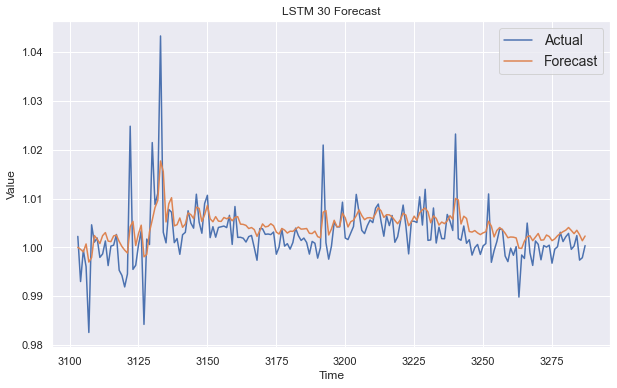

In [72]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [73]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM'] = lstm
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.004620236002363955,
 'SMA 5': 0.003988186526800129,
 'ARIMA': 0.004289278340206155,
 'LSTM': 0.003300976344762655}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

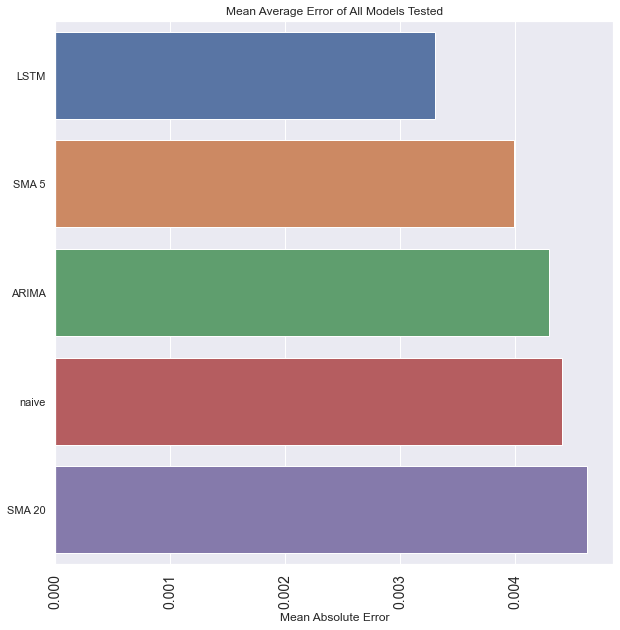

In [74]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [75]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [76]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


23/23 [==============================] - 4s 31ms/step - loss: 0.0923 - mae: 0.4269 - lr: 1.0000e-04
Epoch 2/100
23/23 [==============================] - 1s 32ms/step - loss: 0.0767 - mae: 0.3884 - lr: 1.0798e-04
Epoch 3/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0551 - mae: 0.3271 - lr: 1.1659e-04
Epoch 4/100
23/23 [==============================] - 1s 31ms/step - loss: 0.0279 - mae: 0.2236 - lr: 1.2589e-04
Epoch 5/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0092 - mae: 0.1043 - lr: 1.3594e-04
Epoch 6/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0053 - mae: 0.0756 - lr: 1.4678e-04
Epoch 7/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0033 - mae: 0.0556 - lr: 1.5849e-04
Epoch 8/100
23/23 [==============================] - 1s 34ms/step - loss: 0.0018 - mae: 0.0395 - lr: 1.7113e-04
Epoch 9/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0012 - mae: 0.0312 - lr: 1.8478e-04
Epoc

23/23 [==============================] - 1s 49ms/step - loss: 0.0126 - mae: 0.0963 - lr: 0.0271
Epoch 75/100
23/23 [==============================] - 2s 62ms/step - loss: 0.0013 - mae: 0.0321 - lr: 0.0293
Epoch 76/100
23/23 [==============================] - 1s 40ms/step - loss: 0.0012 - mae: 0.0305 - lr: 0.0316
Epoch 77/100
23/23 [==============================] - 1s 32ms/step - loss: 0.0014 - mae: 0.0358 - lr: 0.0341
Epoch 78/100
23/23 [==============================] - 1s 32ms/step - loss: 0.0012 - mae: 0.0302 - lr: 0.0369
Epoch 79/100
23/23 [==============================] - 1s 28ms/step - loss: 0.0014 - mae: 0.0348 - lr: 0.0398
Epoch 80/100
23/23 [==============================] - 1s 31ms/step - loss: 0.0013 - mae: 0.0313 - lr: 0.0430
Epoch 81/100
23/23 [==============================] - 1s 48ms/step - loss: 0.0013 - mae: 0.0327 - lr: 0.0464
Epoch 82/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0012 - mae: 0.0297 - lr: 0.0501
Epoch 83/100
23/23 [============

(0.0001, 0.1, 0.0, 0.04)

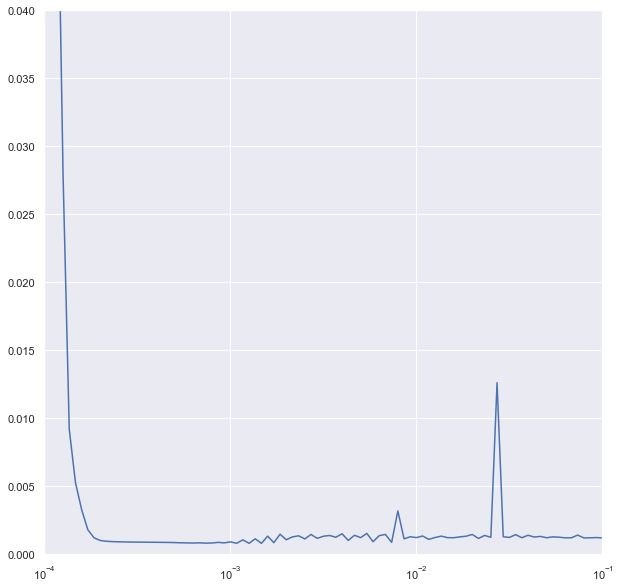

In [77]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [79]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00079 anche qui

0.000786763324867934

In [80]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=0.00079)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
23/23 [==============================] - 8s 200ms/step - loss: 0.0193 - mae: 0.1308 - val_loss: 0.0013 - val_mae: 0.0448
Epoch 2/500
23/23 [==============================] - 3s 140ms/step - loss: 0.0012 - mae: 0.0338 - val_loss: 5.9681e-04 - val_mae: 0.0296
Epoch 3/500
23/23 [==============================] - 4s 140ms/step - loss: 0.0014 - mae: 0.0402 - val_loss: 8.1450e-04 - val_mae: 0.0343
Epoch 4/500
23/23 [==============================] - 3s 132ms/step - loss: 0.0013 - mae: 0.0364 - val_loss: 3.0698e-04 - val_mae: 0.0193
Epoch 5/500
23/23 [==============================] - 3s 140ms/step - loss: 0.0011 - mae: 0.0321 - val_loss: 0.0013 - val_mae: 0.0451
Epoch 6/500
23/23 [==============================] - 5s 199ms/step - loss: 0.0013 - mae: 0.0376 - val_loss: 3.3009e-04 - val_mae: 0.0203
Epoch 7/500
23/23 [==============================] - 4s 165ms/step - loss: 0.0010 - mae: 0.0299 - val_loss: 0.0011 - val_mae: 0.0425
Epoch 8/500
23/23 [==============================] - 

23/23 [==============================] - 4s 165ms/step - loss: 8.2707e-04 - mae: 0.0272 - val_loss: 2.4054e-04 - val_mae: 0.0164
Epoch 60/500
23/23 [==============================] - 4s 146ms/step - loss: 7.3535e-04 - mae: 0.0237 - val_loss: 4.1168e-04 - val_mae: 0.0222
Epoch 61/500
23/23 [==============================] - 3s 131ms/step - loss: 6.6569e-04 - mae: 0.0211 - val_loss: 2.9160e-04 - val_mae: 0.0192
Epoch 62/500
23/23 [==============================] - 3s 145ms/step - loss: 7.0620e-04 - mae: 0.0233 - val_loss: 3.9506e-04 - val_mae: 0.0216
Epoch 63/500
23/23 [==============================] - 3s 133ms/step - loss: 7.2044e-04 - mae: 0.0239 - val_loss: 2.9075e-04 - val_mae: 0.0191
Epoch 64/500
23/23 [==============================] - 4s 172ms/step - loss: 7.3955e-04 - mae: 0.0245 - val_loss: 2.6430e-04 - val_mae: 0.0166
Epoch 65/500
23/23 [==============================] - 5s 214ms/step - loss: 6.9075e-04 - mae: 0.0227 - val_loss: 2.9307e-04 - val_mae: 0.0192
Epoch 66/500
23/23 

Epoch 117/500
23/23 [==============================] - 4s 147ms/step - loss: 5.4386e-04 - mae: 0.0206 - val_loss: 3.0305e-04 - val_mae: 0.0194
Epoch 118/500
23/23 [==============================] - 4s 169ms/step - loss: 5.3159e-04 - mae: 0.0202 - val_loss: 2.4403e-04 - val_mae: 0.0165
Epoch 119/500
23/23 [==============================] - 4s 150ms/step - loss: 5.2791e-04 - mae: 0.0203 - val_loss: 2.6867e-04 - val_mae: 0.0180
Epoch 120/500
23/23 [==============================] - 3s 130ms/step - loss: 4.9507e-04 - mae: 0.0190 - val_loss: 2.3969e-04 - val_mae: 0.0163
Epoch 121/500
23/23 [==============================] - 3s 139ms/step - loss: 5.2514e-04 - mae: 0.0203 - val_loss: 2.7417e-04 - val_mae: 0.0182
Epoch 122/500
23/23 [==============================] - 5s 201ms/step - loss: 5.0373e-04 - mae: 0.0195 - val_loss: 2.4553e-04 - val_mae: 0.0164
Epoch 123/500
23/23 [==============================] - 4s 148ms/step - loss: 5.0815e-04 - mae: 0.0198 - val_loss: 2.7003e-04 - val_mae: 0.0181

In [81]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [82]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

102/102 [==============================] - 3s 16ms/step


(185,)

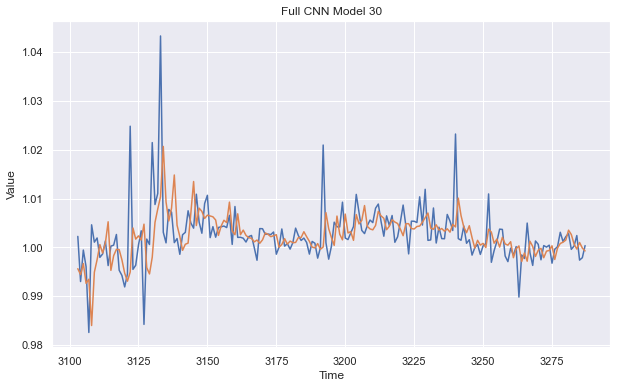

In [83]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [84]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN'] = cnn
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.004620236002363955,
 'SMA 5': 0.003988186526800129,
 'ARIMA': 0.004289278340206155,
 'LSTM': 0.003300976344762655,
 'CNN': 0.0037222993571445753}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

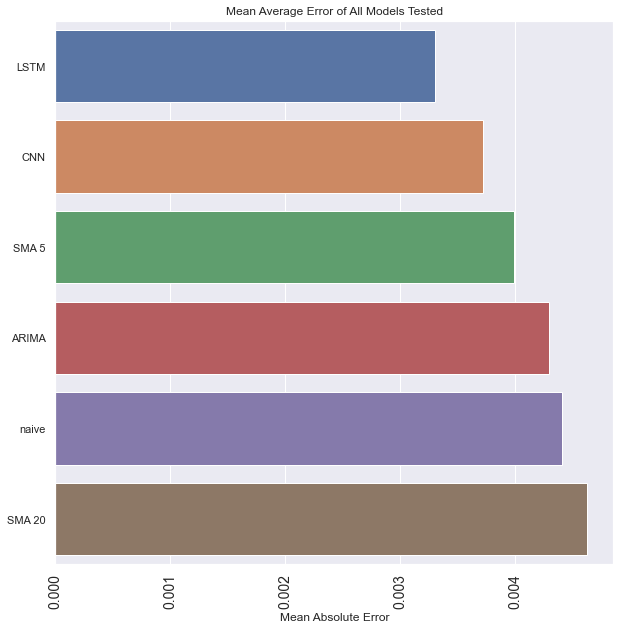

In [85]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')